In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp "/content/drive/MyDrive/School  Học/Data Science/kaggle.json" ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download mlolympiadbd2025

  0% 0.00/8.17k [00:00<?, ?B/s]
100% 8.17k/8.17k [00:00<00:00, 31.4MB/s]


In [ ]:
! unzip mlolympiadbd2025.zip

Archive:  mlolympiadbd2025.zip
  inflating: metaData.csv            
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd

train= pd.read_csv('train.csv')
train
train.shape

test=pd.read_csv('test.csv')
test
test.shape

print(train)

       Id  Age  SystolicBP  DiastolicBP  Blood glucose  BodyTemp  HeartRate  \
0     617   31         120           60            6.1      98.0         76   
1     774   23         120           90            7.8      98.0         60   
2     610   13          90           65            7.5     101.0         80   
3     525   42         120           80            7.5      98.0         70   
4      70   26          85           60            6.0     101.0         86   
..    ...  ...         ...          ...            ...       ...        ...   
806  1012   43         120           90           18.0      98.0         70   
807   481   22         100           65            7.9      98.0         80   
808   458   34          85           60           11.0     102.0         86   
809   309   60          90           65            6.9      98.0         77   
810   326   66          85           60            6.9      98.0         86   

     RiskLevel  Usage  
0            0  Train  
1  

In [ ]:
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
x_columns_drop=["RiskLevel","Usage","Id"]
y=train["RiskLevel"]
X=train.drop(x_columns_drop,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)


Using confusion matrix and classification report .

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

knn= KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train,y_train)

y_pred=knn.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[55  9  1]
 [22 32  5]
 [ 5 10 24]]
              precision    recall  f1-score   support

           0       0.67      0.85      0.75        65
           1       0.63      0.54      0.58        59
           2       0.80      0.62      0.70        39

    accuracy                           0.68       163
   macro avg       0.70      0.67      0.68       163
weighted avg       0.69      0.68      0.68       163



Logistic Regression



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_probs=logreg.predict(X_test)

print(y_pred_probs[:10])

[1 2 2 2 0 2 0 2 2 2]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Used one-hot code to categorize, then used for loop to graph the roc_curve and calculated the auc

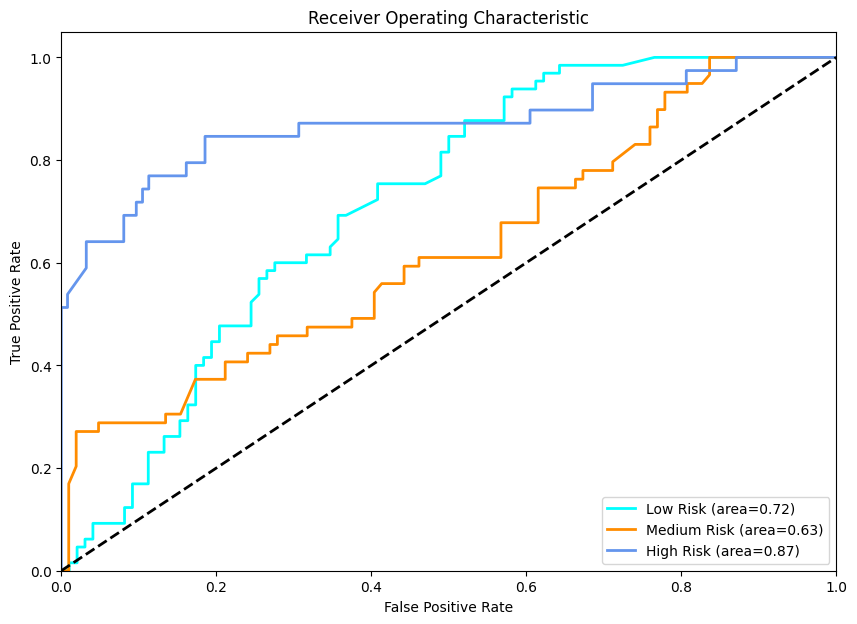

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

#1.predict probabilites of each clas(3 classes)

y_pred_probs=logreg.predict_proba(X_test)

# 2. turn 3 things into one-hot code
from sklearn.preprocessing import OneHotEncoder, label_binarize
y_test_binarized= label_binarize(y_test, classes=[0,1,2])

classes=logreg.classes_
n_classes= len(classes)

#3. Loop through to make ROC curve and area for each class
fpr=dict()
tpr=dict()
roc_auc=dict()

for i in range(n_classes):
  fpr[i],tpr[i], _=roc_curve(y_test_binarized[:,i], y_pred_probs[:,i])
  roc_auc[i]=auc(fpr[i],tpr[i])

#4.. for loop to plot 3

plt.figure(figsize=(10,7))

colors= ["aqua","darkorange","cornflowerblue"]
label_names=["Low Risk","Medium Risk","High Risk"]

for i, color in zip(range(n_classes),colors):
  plt.plot(fpr[i],tpr[i],color=color , lw=2, label=f'{label_names[i]} (area={roc_auc[i]:0.2f})')

plt.plot([0,1],[0,1],'k--',lw=2)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')



# Nice. ill work on the last chapter tmr..

OK... Scaling data...

Dummy variables

In [ ]:
from pandas import get_dummies

dummies= pd.get_dummies(train, drop_first=True)

print("Shape of the dummies is" , dummies.shape)


Shape of the dummies is (811, 8)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

kf=KFold(n_splits=5, shuffle= True, random_state=12)


X = dummies.drop("RiskLevel", axis=1).values
y= dummies["RiskLevel"].values

ridge= Ridge(alpha=0.2)

scores= cross_val_score(ridge, X, y, cv=kf, scoring="neg_mean_squared_error")

rmse=np.sqrt(-scores)
print(f"Average RMSE : {np.mean(rmse)}")

print(f"Standard Deviation of the array is {np.std(y)}")

Average RMSE : 0.6081938546596543
Standard Deviation of the array is 0.8065833895586492


Handle Missing Data

In [ ]:
# Print missing values for each column
print(dummies.isna().sum().sort_values())

# Convert Heartrates to where the heartrate column is more than 70
dummies["HeartRate"] = np.where(dummies["HeartRate"]>= 70, 1,0)


print(f"Shape of the dummies is {dummies.shape}")

Id               0
Age              0
SystolicBP       0
DiastolicBP      0
Blood glucose    0
BodyTemp         0
HeartRate        0
RiskLevel        0
dtype: int64
Shape of the dummies is (811, 8)


Implementing Pipelines


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

imputer=SimpleImputer()

knn= KNeighborsClassifier(n_neighbors = 3)

steps = [("imputer", imputer),
         ("knn",knn)]
#Create pipeline
pipeline=Pipeline(steps)

#fit model
pipeline.fit(X_train,y_train)

#Make predictions on test set
y_pred= pipeline.predict(X_test)

#Print confusion matrix
print(confusion_matrix(y_test,y_pred))

[[49 15  1]
 [12 43  4]
 [ 5  8 26]]


Centering and Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

#Create pipeline steps
steps= [("scaler",StandardScaler()),
        ("lasso",Lasso(alpha=0.5))]

# Insantiate Pipeline
pipeline=Pipeline(steps)

# Fit data
pipeline.fit(X_train,y_train)


#Print R-squared
print(pipeline.score(X_test,y_test))

-0.0017740254285647516


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# Have the steps for pipeline
steps = [("scaler",StandardScaler()),
         ("logreg", LogisticRegression())]

# Insantiate the pipeline
pipeline=Pipeline(steps)

#Create parameter space
parameters = {"logreg__C" : np.linspace(0.001,1.0,20)}

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=21)

# Insantiate GridSearch
cv= GridSearchCV(pipeline , param_grid= parameters)

#Fit Gridsearch
cv.fit(X_train,y_train)

# Print best score and best parameters
print(cv.best_score_)
print(cv.best_params_)



0.6234943351222422
{'logreg__C': np.float64(0.05357894736842105)}


/tmp/ipython-input-3433865369.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys())


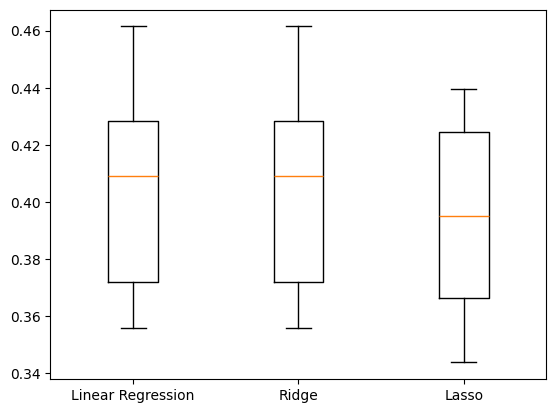

In [ ]:
import matplotlib.pyplot as plt

#Get models
models= {"Linear Regression": LinearRegression(),
         "Ridge" : Ridge(alpha=0.1),
         "Lasso": Lasso(alpha=0.1)}

results=[]

# Loop through model values
for model in models.values():
  kf=KFold(n_splits=6, random_state=42, shuffle=True)

# cross validation.. renember to use model(single), not models since we're looping through
  cv_scores= cross_val_score(model,X_train, y_train, cv=kf)

  results.append(cv_scores)

# Plot
plt.boxplot(results, labels=models.keys())

plt.show()

Predicting on Test Set

In [ ]:
from sklearn.metrics import root_mean_squared_error

from sklearn.preprocessing import StandardScaler

#Insantiate standard scaler
scaler=StandardScaler()

# Scale the X and ys
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

for name, model in models.items():
  # Fit model
  model.fit(X_train_scaled, y_train)
# preditct
  y_pred = model.predict(X_test_scaled)
# calculate the test_rmse
  test_rmse= root_mean_squared_error(y_test,y_pred)

  print(f"Test Set RMSE :{name,test_rmse}")


Test Set RMSE :('Linear Regression', 0.5922877917333388)
Test Set RMSE :('Ridge', 0.5922981994423419)
Test Set RMSE :('Lasso', 0.6596086316481967)


Visualizing performance of models

/tmp/ipython-input-2698983499.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels= models.keys())


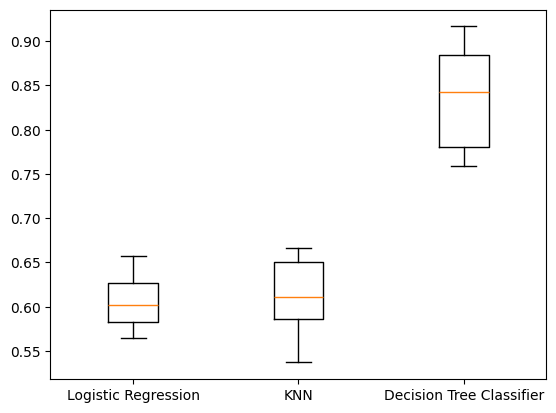

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#create the models dictionary
models= {"Logistic Regression": LogisticRegression(),
         "KNN" : KNeighborsClassifier(),
         "Decision Tree Classifier": DecisionTreeClassifier()}

results=[]

#Loop through
for model in models.values():
  kf=KFold(n_splits=6, random_state=12, shuffle=True)

#cross validation , again use individual 'model'
  cv_results= cross_val_score(model, X_train_scaled, y_train, cv=kf)

  results.append(cv_results)
#Plot
plt.boxplot(results, labels= models.keys())

plt.show()

Pipeline for predictions

In [ ]:
# Have steps for imputer, scaler and logistic reg
steps = [("imp_mean", SimpleImputer()),
         ("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]

# Insantiate pipeline
pipeline = Pipeline(steps)

# Build parameters
params = {"logreg__C" : np.linspace(0.001,1.0, 10)}

# Create Gridsearch Object
tuning= GridSearchCV(pipeline, param_grid= params)

#Fit gridserach
tuning.fit(X_train,y_train)
# Predict
y_pred = tuning.predict(X_test)

# Print
print(f"Tuned Logistic Regression Parameters : {tuning.score(X_test,y_test)}")

Tuned Logistic Regression Parameters : 0.6503067484662577
